In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn import model_selection
from sklearn import metrics

import os
from scipy.stats import rankdata

In [ ]:
class ModelConfig:
    vocabulary_size = 20000
    batch_size = 256
    num_epochs = 50
    target_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    label_weights = [1, 2, 2, 5, 1, 2]
    output_dataset_directory = "../input/tfidf-vectorization-with-keras-output"
    best_accuracy_model_path = "model_best_acc.tf"
    best_auc_model_path = "model_best_auc.tf"
    best_loss_model_path = "model_best_loss.tf"
    latest_model_path = "model_latest.tf"
    model_file_paths = [best_accuracy_model_path, best_auc_model_path, latest_model_path, best_loss_model_path]
    operation_modes = ["training", "inference"]
    current_mode = operation_modes[0]

config = ModelConfig()

## Prepare the data


In [ ]:
training_data = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
training_data = training_data.rename(columns={'comment_text': 'text'})
training_data.head()

,id,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## TF-IDF vectorization

In [ ]:
text_data = training_data["text"]
tfidf_vectorizer = layers.TextVectorization(max_tokens=config.vocabulary_size, output_mode="tf-idf", ngrams=2)

with tf.device("CPU"):
    tfidf_vectorizer.adapt(text_data)

2021-12-04 08:57:15.120716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 08:57:15.291759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 08:57:15.292945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 08:57:15.295434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
target_data = training_data[config.target_labels]
target_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The output of the vectorizer:

In [ ]:
sample_batch = tfidf_vectorizer(X[0:config.batch_size])
sample_batch.shape

TensorShape([256, 20000])

## Model Development

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(None, ), dtype="string"),
    tfidf_vectorizer,
    layers.Dense(256, activation="relu", kernel_regularizer="l2"),
    layers.Dense(32, activation="relu", kernel_regularizer="l2"),
    layers.Dense(len(config.target_labels), activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["categorical_accuracy", keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 20000)             1         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,128,679
Trainable params: 5,128,678
Non-trainable params: 1
_________________________________________________________________


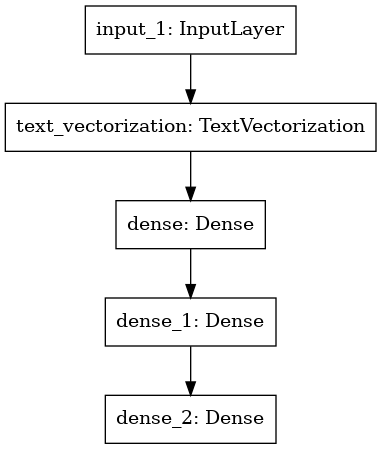

In [ ]:
keras.utils.plot_model(model)

## Train Validation Split

In [ ]:
train_text_data, val_text_data, train_labels, val_labels = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
train_text_data.shape, val_text_data.shape, train_labels.shape, val_labels.shape

((127656,), (31915,), (127656, 6), (31915, 6))

## Model Training

In [ ]:
if config.current_mode == config.operation_modes[0]:
    best_accuracy_checkpoint = keras.callbacks.ModelCheckpoint(config.best_accuracy_model_path, save_best_only=True, save_weights_only=True, monitor="val_categorical_accuracy")
    best_auc_checkpoint = keras.callbacks.ModelCheckpoint(config.best_auc_model_path, save_best_only=True, save_weights_only=True, monitor="val_auc")
    best_loss_checkpoint = keras.callbacks.ModelCheckpoint(config.best_loss_model_path, save_best_only=True, save_weights_only=True, monitor="val_loss")
    learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    classification_model.fit(train_text_data, train_labels, epochs=config.num_epochs, batch_size=config.batch_size, validation_data=(val_text_data, val_labels), callbacks=[best_accuracy_checkpoint, best_auc_checkpoint, best_loss_checkpoint, learning_rate_reduction])
    classification_model.save_weights(config.latest_model_path)

Epoch 1/50
499/499 [==============================] - 15s 26ms/step - loss: 0.3691 - categorical_accuracy: 0.8380 - auc: 0.8843 - val_loss: 0.1922 - val_categorical_accuracy: 0.9695 - val_auc: 0.9356
Epoch 2/50
499/499 [==============================] - 12s 24ms/step - loss: 0.1600 - categorical_accuracy: 0.9792 - auc: 0.9436 - val_loss: 0.1554 - val_categorical_accuracy: 0.9941 - val_auc: 0.9365
Epoch 3/50
499/499 [==============================] - 13s 25ms/step - loss: 0.1457 - categorical_accuracy: 0.9885 - auc: 0.9479 - val_loss: 0.1395 - val_categorical_accuracy: 0.9941 - val_auc: 0.9574
Epoch 4/50
499/499 [==============================] - 12s 24ms/step - loss: 0.1366 - categorical_accuracy: 0.9932 - auc: 0.9534 - val_loss: 0.1350 - val_categorical_accuracy: 0.9941 - val_auc: 0.9548
Epoch 5/50
499/499 [==============================] - 12s 24ms/step - loss: 0.1311 - categorical_accuracy: 0.9941 - auc: 0.9564 - val_loss: 0.1311 - val_categorical_accuracy: 0.9941 - val_auc: 0.9587


## Model Evluation


In [ ]:
def evaluate_model(classification_model, model_file_path, val_text_data, val_labels):
    print("Evaluation of %s" % (model_file_path))
    model_weights_path = model_file_path
    if config.current_mode == config.operation_modes[1]:
        model_weights_path = os.path.join(config.output_dataset_directory, model_weights_path)
    classification_model.load_weights(model_weights_path)
    prediction_result = np.array(classification_model.predict(val_text_data) > 0.5, dtype=int)
    for i in range(len(config.target_labels)):
        class_report = metrics.classification_report(val_labels[config.target_labels[i]], prediction_result[:, i])
        print("Classification Report for %s" % config.target_labels[i])
        print(class_report)

In [ ]:
for model_file_path in config.model_file_paths:
    evaluate_model(classification_model, model_file_path, val_text_data, val_labels)

Evaluation of model_best_acc.tf
Classification Report of toxic
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28859
           1       0.98      0.19      0.32      3056

    accuracy                           0.92     31915
   macro avg       0.95      0.60      0.64     31915
weighted avg       0.93      0.92      0.90     31915

Classification Report of severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.00      0.00      0.00       321

    accuracy                           0.99     31915
   macro avg       0.49      0.50      0.50     31915
weighted avg       0.98      0.99      0.98     31915

Classification Report of obscene
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     30200
           1       0.93      0.21      0.35      1715

    accuracy                           0.96     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report of toxic
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28859
           1       0.96      0.20      0.32      3056

    accuracy                           0.92     31915
   macro avg       0.94      0.60      0.64     31915
weighted avg       0.92      0.92      0.90     31915

Classification Report of severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.55      0.11      0.19       321

    accuracy                           0.99     31915
   macro avg       0.77      0.56      0.59     31915
weighted avg       0.99      0.99      0.99     31915

Classification Report of obscene
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     30200
           1       0.90      0.20      0.33      1715

    accuracy                           0.96     31915
   macro avg       0.93   